Sept 24, 2018

Trying to construct heatmap to showcase how each individual node reacts... 


Notes: We need frequency in log sclae and we need the plots in log scale.. Perhaps the best metric will indeed be to use coherence??

In [40]:
import sys
import os
sys.path.append("../Classes")



from HomGraph import *
from SFGraph import *
from sighelp import *
from matplotlib.pyplot import cm
from matplotlib.mlab import frange
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import sparse
import scipy as scp
from decimal import Decimal
from scipy.sparse import csgraph

import networkx as nx 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


from matplotlib import rcParams
sns.set(context='paper',font_scale = 7,
        rc = {'figure.figsize' : (20,10), 'legend.frameon':True, 
              'legend.loc': 'upper right', "xtick.major.size": 10,"ytick.major.size": 10,
             "xtick.minor.size": 6,"ytick.minor.size": 6, 
              "xtick.major.width": 3, "ytick.major.width": 3,
             "xtick.minor.width": 1, "ytick.minor.width": 1, 
             "xtick.labelsize": 40, "ytick.labelsize": 40})

# sns.set_style("white")
sns.set_style("ticks")

#Friday July 14

In [9]:
# Load graph...
n = 1000
gam = 1.9
period = 8 #10

prefix = "/Users/Sam/Documents/Harvard/Research/Results/Oscillating/Clustering/example/"
my_graph = Graph.load_graph(graph_file=prefix+"n1000gam19_interesting_downstream_graph.npy", 
                    state_file=prefix+"n1000gam19_interesting_downstream_state.npy")

# my_graph = SFGraph(n, 1.9)

In [3]:
# Get ordering... 
out_order = np.flip(np.argsort(my_graph.out_degree()), axis=0)
# out_order[2]

In [4]:
# Find out node
oscil_node = out_order[0]
# my_graph.out_degree()[oscil_node]



In [5]:
## Create initial oscillation table

In [10]:
start_config = np.copy(my_graph.get_config())
my_graph.set_config(np.copy(start_config))
tbl = my_graph.oscillate_update(force_start_on=False, node_index=oscil_node, oscil_shift=0, period=period, time=4000)
my_graph.set_config(np.copy(start_config))

In [11]:



tbl_copy = np.copy(tbl)
tbl_copy[:, oscil_node] = 0 
Graph.find_attractor(tbl_copy)

freqs, power_spectra = signal.periodogram(tbl_copy.T)

In [12]:
freqs.shape, power_spectra.shape

((2001,), (1000, 2001))

In [13]:
# attractors
start, stop = Graph.find_attractor_in_oscillations(tbl, period=period)

In [14]:
# Take power spectra
PSD = signal.periodogram(x=tbl[start:stop+(stop-start)*3:, ].T)

In [15]:
start, stop

(16, 40)

In [16]:
freqs[freqs == 0] = 0.0000001
1 / freqs

array([1.0000000e+07, 4.0000000e+03, 2.0000000e+03, ..., 2.0020020e+00,
       2.0010005e+00, 2.0000000e+00])

Trying to use pcolor

In [17]:
# freqs = CSD[0]
# cross_spectra = CSD[1]
freqs = PSD[0]
power_spectra = PSD[1]

In [18]:
### Normalize by the max
power_spectra /= np.max(power_spectra)



In [19]:
index = np.where(freqs == 1/4)[0]
if len(index) == 0 : 
    raise Exception("Could not find")


    
indices = np.flip(
    np.argsort(power_spectra[:, index], axis=0).squeeze(1)
)
print(indices[0], oscil_node)
power_spectra[indices,index]

print(indices[0])
#np.argsort(power_spectra[: , index])

325 329
325


In [20]:
per = 10 
freqs_2 = 1 / np.arange(1, per)
np.where([i in freqs_2 for i in freqs]), freqs_2

((array([12, 16, 24, 32, 48]),),
 array([1.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
        0.16666667, 0.14285714, 0.125     , 0.11111111]))

In [21]:
##### Trying to choose a subset for the heatmap... 
##### Build mesh grid
# choose only the indices of the main modes of any node, not 0
# old way of doing filtering
# new_indices = sorted(list(set(np.argmax(cross_spectra, axis=1))))[1:]

top_n_modes = 0 # 1 is the most stringent filter, 0 the most relaxed, 5 is moderate, etc.
new_indices = set(np.argsort(power_spectra, axis=1)[:, -top_n_modes:].flatten())
if 0 in new_indices: 
    # remove the 0 frequency if it exists
    new_indices.remove(0)
new_indices = sorted(list(new_indices))

frequencies_filtered = freqs[new_indices]
# Choose important freqs
power_filtered = power_spectra[:, new_indices]


oscil_power = power_filtered[oscil_node]

# Additionally only choose important rows
remember_power_filtered = np.copy(power_filtered)
power_filtered = power_filtered[np.sum(power_spectra ** 2, axis=1) > 0, :]

diff = frequencies_filtered[-1] - frequencies_filtered[-2]
# Add a padd at the very end for last freq block
freq_blocks = np.insert(frequencies_filtered, 
                                 len(frequencies_filtered), frequencies_filtered[-1] + diff
                                )
freq_blocks = freq_blocks  #np.logspace(np.log10(frequencies_filtered[0]), np.log10(frequencies_filtered[-1]), len(frequencies_filtered))
node_blocks = np.arange(0, power_filtered.shape[0])
y, x = np.meshgrid(node_blocks, freq_blocks)

In [22]:
# select nodes with the lowest frequency represented!!!
# Use this for cherrypicking nodes...
# np.argwhere(np.logical_and(np.sum(cross_spectra ** 2, axis = 1) > 0, cross_spectra[:, new_indices[0]] > 0.7))

In [23]:
# Define color..
# levels = MaxNLocator(nbins=20).tick_values(np.abs(cross_spectra).min(), np.abs(cross_spectra).max())
norm=colors.LogNorm(vmin=np.abs(power_filtered).min()+0.001, vmax= np.abs(power_filtered).max())
# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('Reds')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

In [24]:
#### some misc tests on selection
# ((1 / frequencies_filtered[1:]).astype(int))
# frequencies_filtered[1], frequencies_filtered[7]
# 1 / 0.00025, 1 / 0.0715
# np.max(power_filtered[:, [1,7]], axis=0), power_filtered[[273, 122, 122, 273], [1,7, 1, 7]]
# power_filtered[oscil_node, 7]

In [33]:
### Choose input frequencies
non_zero_freq_indices= np.argwhere(
    np.expand_dims(
        np.abs(oscil_power).T, axis=1
    ) > 0.001
)[:, 0]

In [32]:
freq_indices = frequencies_filtered[non_zero_freq_indices]  
freq_indices

array([0.125, 0.375])

In [28]:
# For input = 8 
names = {freq_indices[0] : {"num": 1, "denom" : 1,  "val" : "$N_0$" }, 
         np.round(1/2 * freq_indices[0], 6) : {"num": 1, "denom" : 2 , "val" : "$N_0$" }, 
         np.round(1/3 * freq_indices[0], 6) : {"num": 1, "denom" : 3 , "val" : "$N_0$" },
        }

# For input = 10
# names = {freq_indices[0] : {"num": 1, "denom" : 1,  "val" : "$N_0$" }}


In [29]:
def convert_index_to_freq(x, refs): 
    ''' Come up with a labeling scheme based upon the fundamentals '''
    names = []
    for val in x: 
        found = False
        for i in np.arange(1,20): #np.linspace(0.25, 10, 40): 
            if np.round(val / i, 6) in refs: 
                found = True
                entry = refs[np.round(val / i, 6)]
                entry_num = entry["num"]
                entry_denom = entry["denom"]
                entry_val = entry["val"]
                entry_num *= i
                if entry_denom == 1: 
                    names.append(str(entry_num))# + entry_val)
                else: 
                    names.append(f"$\\frac{{{entry_num}}}{{{entry_denom}}}$")# + entry_val)
                break 
        if not found: 
            names.append("")
            
    return names



convert_index_to_freq(frequencies_filtered, names)
                
    
    
    

['',
 '',
 '',
 '$\\frac{1}{3}$',
 '',
 '$\\frac{1}{2}$',
 '',
 '$\\frac{2}{3}$',
 '',
 '',
 '',
 '1',
 '',
 '',
 '',
 '$\\frac{4}{3}$',
 '',
 '$\\frac{3}{2}$',
 '',
 '$\\frac{5}{3}$',
 '',
 '',
 '',
 '2',
 '',
 '',
 '',
 '$\\frac{7}{3}$',
 '',
 '$\\frac{5}{2}$',
 '',
 '$\\frac{8}{3}$',
 '',
 '',
 '',
 '3',
 '',
 '',
 '',
 '$\\frac{10}{3}$',
 '',
 '$\\frac{7}{2}$',
 '',
 '$\\frac{11}{3}$',
 '',
 '',
 '',
 '4']

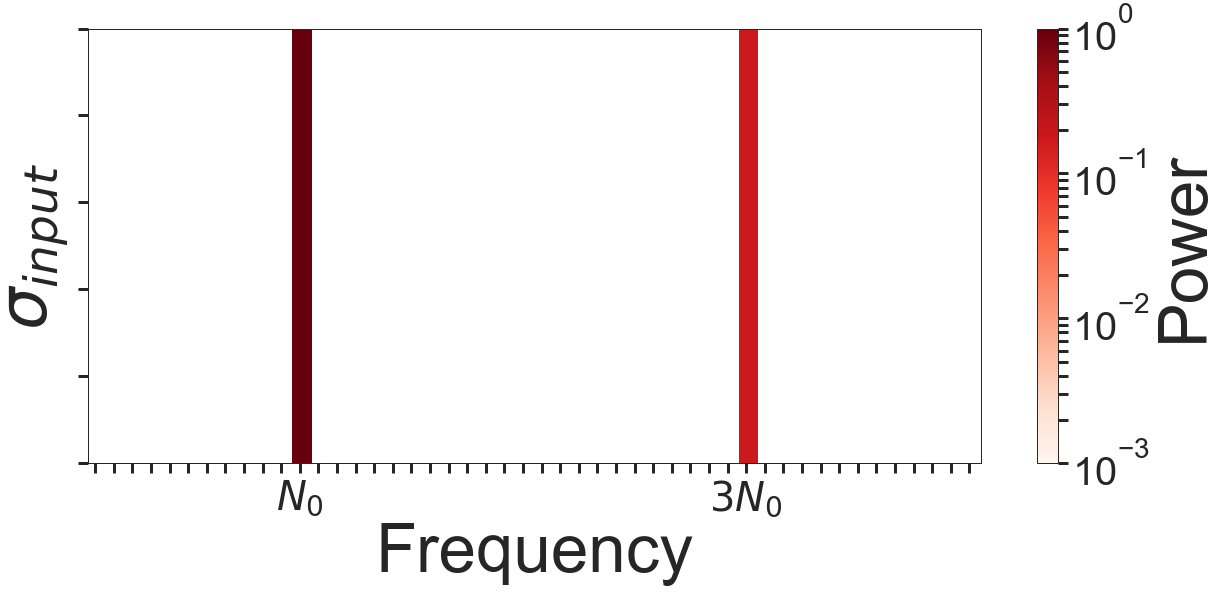

In [35]:

## Test node...
plt.figure(figsize=(20,8))
freq_blocks_hub = freq_blocks #np.logspace(np.log10(frequencies_filtered[0]), np.log10(frequencies_filtered[-1]), len(frequencies_filtered))
node_blocks_hub = np.arange(0, 2)
y_hub, x_hub = np.meshgrid(node_blocks_hub, freq_blocks_hub)
cf = plt.pcolormesh(x_hub,y_hub, np.expand_dims(np.abs(oscil_power).T, axis=1),  norm=norm, cmap=cmap,
                    linewidths=0,)

# plt.colorbar(cf)
cbar = plt.colorbar(cf)
cbar.set_label("Power", rotation=90)
# cbar.set_ticks([])
# plt.axis('off')
# plt.xscale('log')
plt.ylabel(r'$\sigma_{input}$')
plt.xlabel("Frequency")
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.xaxis.set_ticklabels([])


## Label the x axis
# Input = 8 
hub_labels = {freq_indices[0] : "$N_0$" , freq_indices[1]: "$3N_0$"}
dist = 0.004

# Input = 10
# hub_labels = {freq_indices[0] : "$N_0$" , freq_indices[1]: "$3N_0$",  
#               freq_indices[2]: "$5N_0$"}
# dist = 0.01

labels = [hub_labels[i] if i in hub_labels else "" for i in frequencies_filtered]


plt.xticks(freq_blocks_hub+dist, labels, 
          rotation = 0, fontsize=40)
plt.xlim(freq_blocks_hub[0], freq_blocks_hub[-1])


# plt.tight_layout()

# plt.savefig("/Users/Sam/Desktop/InputPower.png", bbox_inches="tight", dpi=300)

plt.show()





In [36]:
#### If we want to only take the maximum mode... 
max_mode = False
if max_mode: 
    temp = np.argmax(power_filtered, axis=1)
    for index, j in enumerate(power_filtered):
        power_filtered[index] = [x if i == temp[index] else 0 for i,x in enumerate(j)]

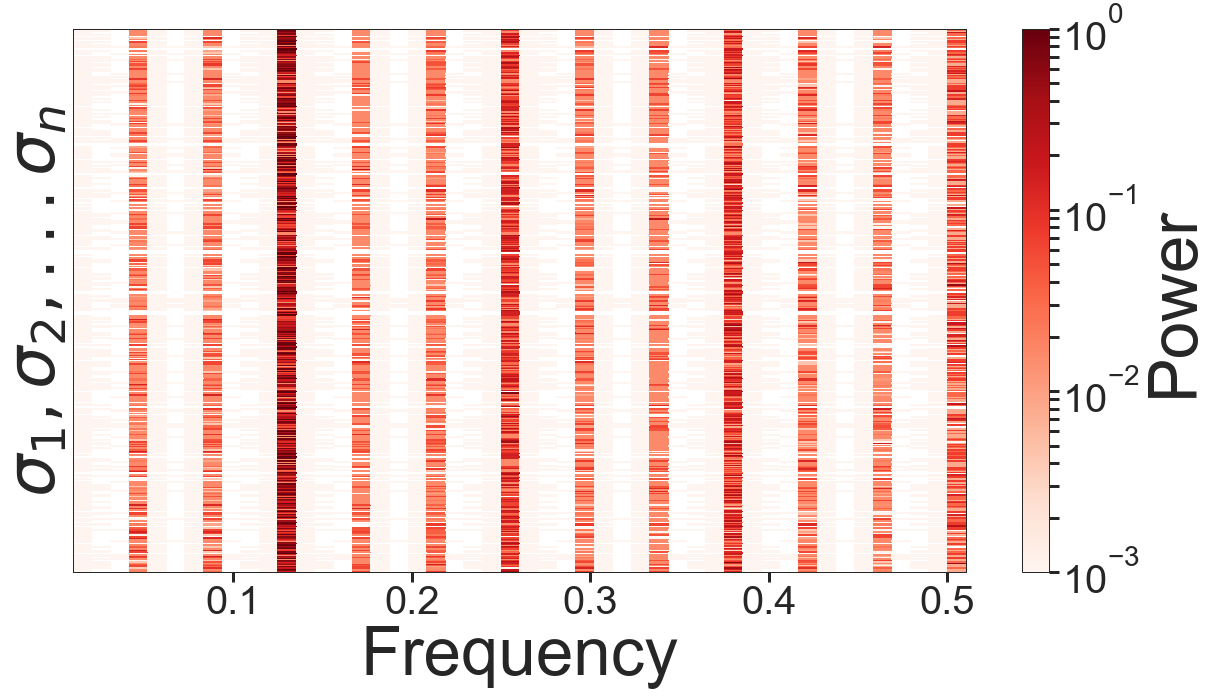

In [41]:

# cf = plt.contourf(x,y, np.abs(cross_spectra).T, levels=levels, cmap=cmap)
# cf = plt.pcolormesh(x,y, np.abs(cross_spectra).T + 1,  norm=norm, cmap=cmap)
cf = plt.pcolormesh(x,y, np.abs(power_filtered).T,  norm=norm, cmap=cmap,
                    linewidths=0,)


cf = plt.pcolormesh(x ,y, np.abs(power_filtered).T,  norm=norm, cmap=cmap,
                    linewidths=0,)

cf.set_edgecolor('face')

cbar = plt.colorbar(cf)
cbar.set_label("Power", rotation=90)

plt.yticks([])
# plt.ylim([900,950])
plt.xlabel('Frequency')
plt.ylabel(r'$\sigma_1,\sigma_2,...\sigma_n$')
# plt.tight_layout()

# plt.xticks(freq_blocks_hub, 
#            ["{:.1E}".format(Decimal(i)) if index % 20 == 0 else "" for index, i in enumerate(frequencies_filtered[:])])

# plt.xticks(freq_blocks_hub, convert_index_to_freq(frequencies_filtered, names), 
#           rotation = 70, fontsize=25)






# plt.savefig("/Users/Sam/Desktop/powerspectra.png", dpi=300, bbox_inches="tight")
plt.show()

# adjust spacing between subplots so `ax1` title and `ax0` tick labels
# don't overlap



### Trying to produce both plots on one graph for alignment

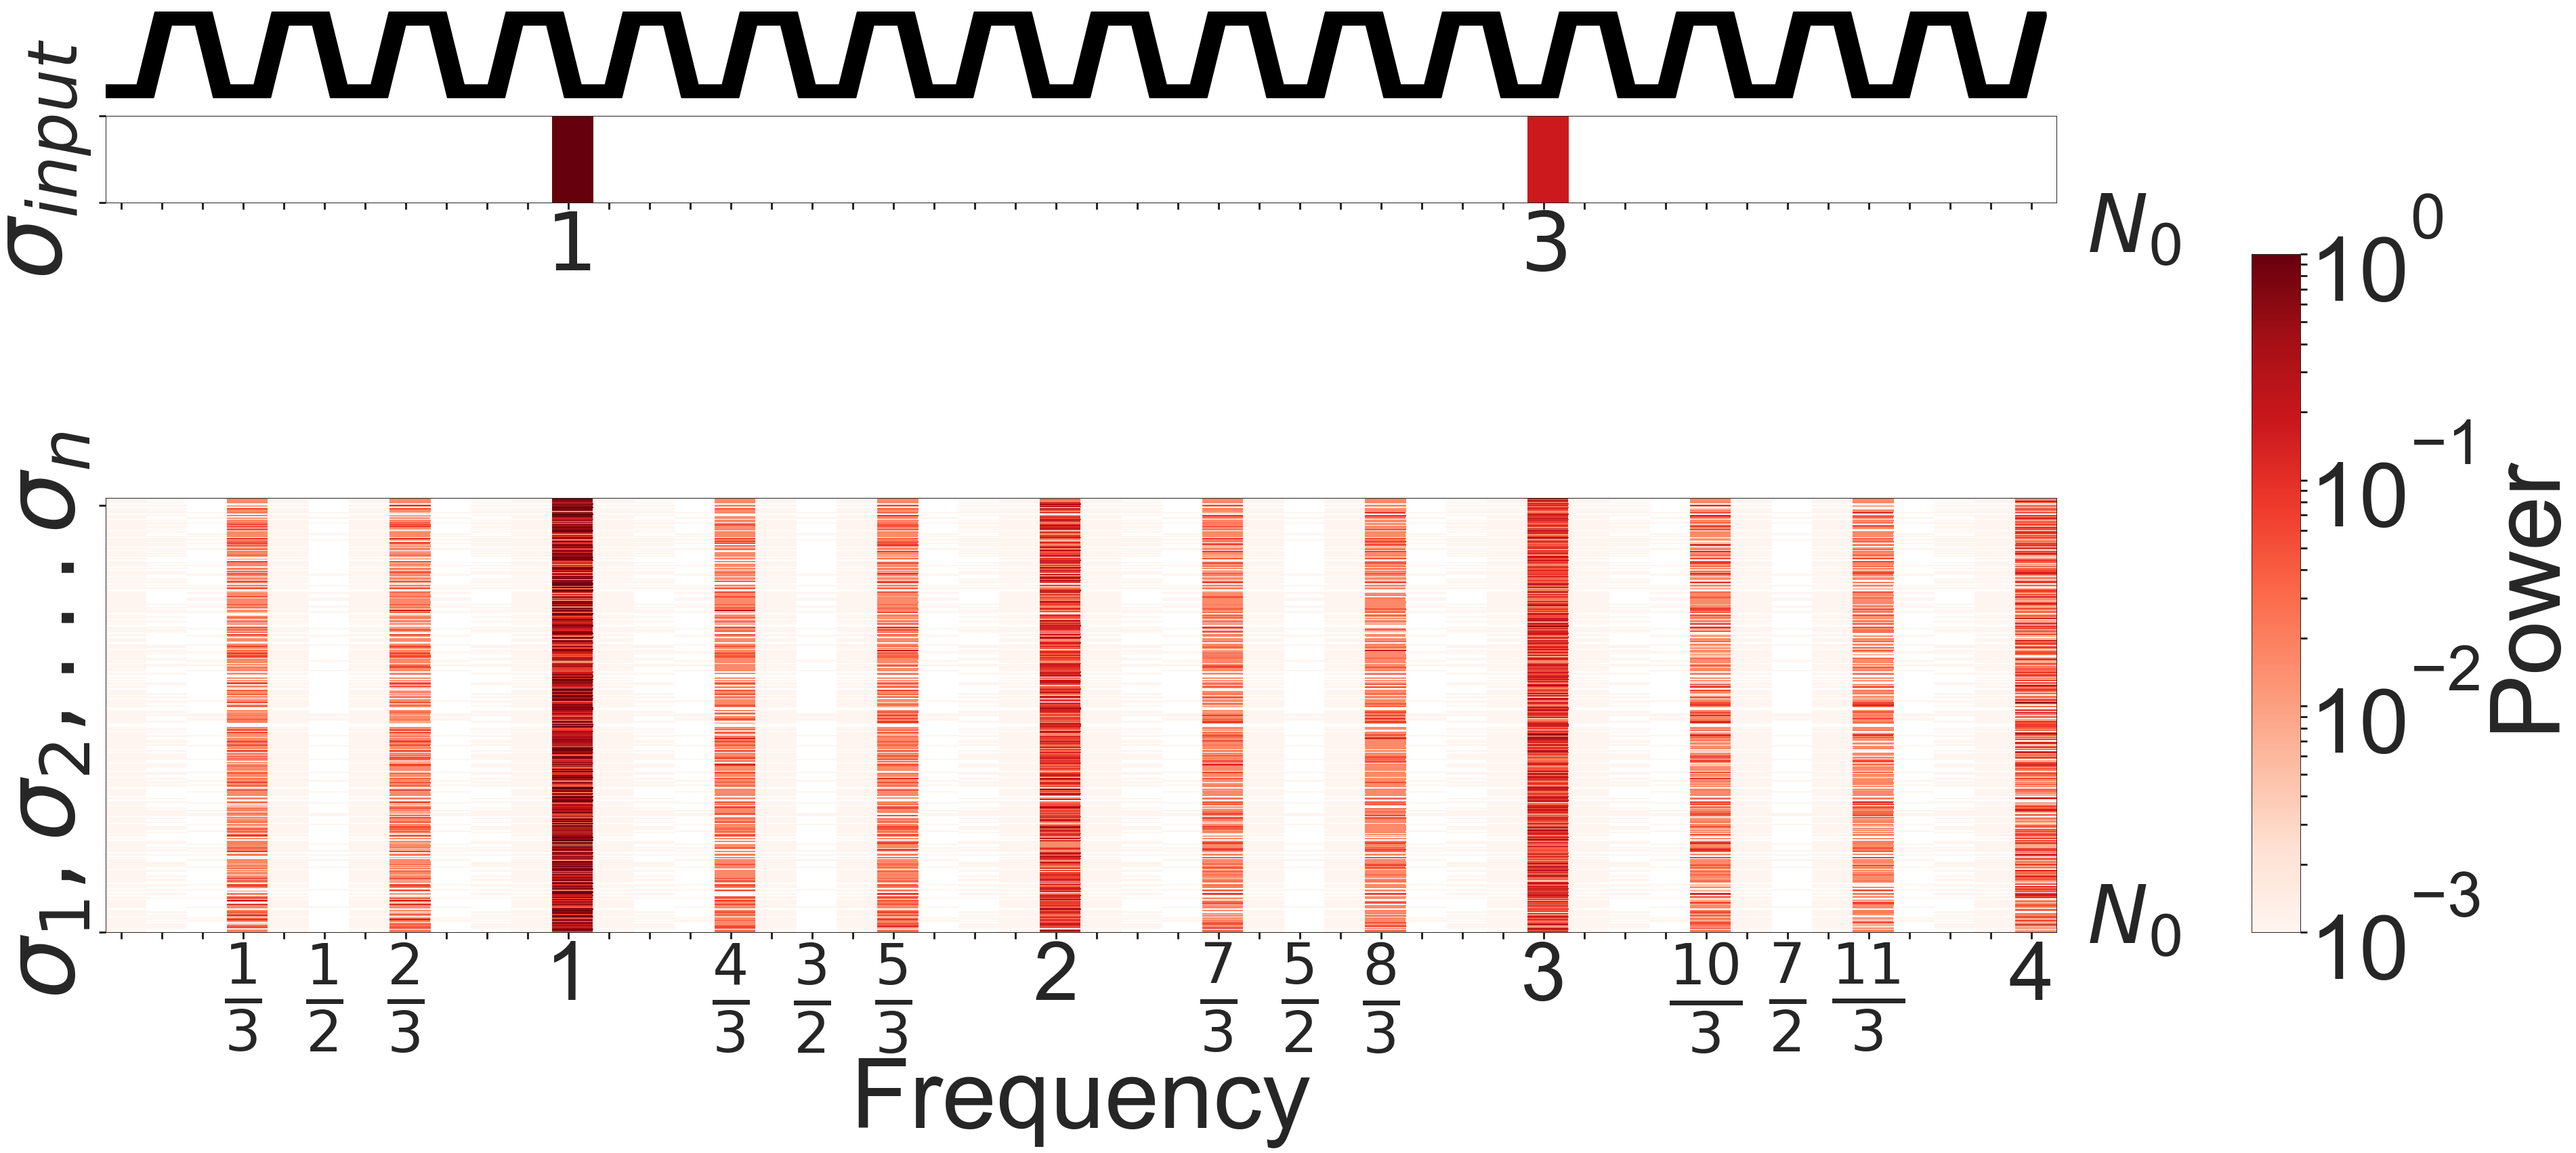

In [44]:
import matplotlib.gridspec as gridspec
sns.set(context='paper',font_scale = 15,
        rc = {'figure.figsize' : (20,10), 'legend.frameon':True, 
              'legend.loc': 'upper right', "xtick.major.size": 10,"ytick.major.size": 10,
             "xtick.minor.size": 6,"ytick.minor.size": 6, 
              "xtick.major.width": 3, "ytick.major.width": 3,
             "xtick.minor.width": 1, "ytick.minor.width": 1, "lines.linewidth" : 30})

# sns.set_style("white")
sns.set_style("ticks")




# Make subplots
# Invisible 3rd one
fig, axes = plt.subplots(nrows=4, sharex=False,gridspec_kw = {'height_ratios':[1,1,3,5]}, figsize=(50,25))

n__ = 100
sq_wave = [(i // 3) % 2 for i in range(n__)]
axes[0].plot(range(n__), sq_wave, color="black")

# axes[0].set_ylabel(r'$\sigma_{input}$')
# axes[0].set_xlabel(r'Time, $t$')

# axes[0].grid(False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_xticks([])
axes[0].set_yticks([])



plt.sca(axes[0])
plt.box(on=None)
sns.despine(ax=axes[0], left=True, bottom=True)
axes[0].set_xlim([0,100])


# Heatmap input
axes[1].pcolormesh(x_hub,y_hub, np.expand_dims(np.abs(oscil_power).T, axis=1),  norm=norm, cmap=cmap,
                    linewidths=0,)

axes[1].set_ylabel(r'$\sigma_{input}$')
axes[1].yaxis.set_ticklabels([])


## For input = 8 
hub_labels = {freq_indices[0] : "$1$" , freq_indices[1]: "$3$"}
labels = [hub_labels[i] if i in hub_labels else "" for i in frequencies_filtered]
dist = 0.004


# For input = 10 
# hub_labels = {freq_indices[0] : "$1$" , freq_indices[1]: "$3$",  
#               freq_indices[2]: "$5$"}
# labels = [hub_labels[i] if i in hub_labels else "" for i in frequencies_filtered]
# dist = 0.01




plt.sca(axes[1])
plt.xticks(freq_blocks_hub+dist, labels, 
          rotation = 0, fontsize=120)
plt.xlim(freq_blocks_hub[0], freq_blocks_hub[-1])


axes[2].set_visible(False)



# Heatmap all nodes
cf = axes[3].pcolormesh(x,y, np.abs(power_filtered).T,  norm=norm, cmap=cmap,
                    linewidths=0)
cf.set_edgecolor('face')


axes[3].yaxis.set_ticklabels([])

# plt.ylim([900,950])
axes[3].set_xlabel('Frequency')
axes[3].set_ylabel(r'$\sigma_1,\sigma_2,...\sigma_n$')


plt.sca(axes[3])
plt.xticks(freq_blocks_hub+dist, convert_index_to_freq(frequencies_filtered, names), 
          rotation = 0, fontsize=120)

plt.xlim(freq_blocks_hub[0], freq_blocks_hub[-1])



# Add n_0
axes[1].text(1.04, 0.11, '$N_0$',
        horizontalalignment='center',
        verticalalignment='top',
        transform=axes[1].transAxes, fontsize=120)


axes[3].text(1.04, 0.11, '$N_0$',
        horizontalalignment='center',
        verticalalignment='top',
        transform=axes[3].transAxes, fontsize=120)


# Add colorbar
fig.subplots_adjust(left=0.07, right=0.87, hspace=0.08)
pad, width = 0.08, 0.02
box = axes[3].get_position()
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height+0.2])
cbar = fig.colorbar(cf, cax=cax)
cbar.set_label("Power", rotation=90)



# fig.colorbar(cf, orientation='horizontal')

plt.savefig("/Users/Sam/Desktop/powerspectra.png", dpi=200, bbox_inches="tight")





In [30]:
frequencies_filtered

array([0.01041667, 0.02083333, 0.03125   , 0.04166667, 0.05208333,
       0.0625    , 0.07291667, 0.08333333, 0.09375   , 0.10416667,
       0.11458333, 0.125     , 0.13541667, 0.14583333, 0.15625   ,
       0.16666667, 0.17708333, 0.1875    , 0.19791667, 0.20833333,
       0.21875   , 0.22916667, 0.23958333, 0.25      , 0.26041667,
       0.27083333, 0.28125   , 0.29166667, 0.30208333, 0.3125    ,
       0.32291667, 0.33333333, 0.34375   , 0.35416667, 0.36458333,
       0.375     , 0.38541667, 0.39583333, 0.40625   , 0.41666667,
       0.42708333, 0.4375    , 0.44791667, 0.45833333, 0.46875   ,
       0.47916667, 0.48958333, 0.5       ])

<function numpy.core.fromnumeric.repeat(a, repeats, axis=None)>

In [75]:
frequencies_filtered[oscil_power > 0.01]

array([0.25])